## **1. Introdução**

Tendo em vista a influência que os K-Dramas, novelas coreanas, tem ao redor do mundo, esse projeto tem como intuito prever a média da avaliação dos usuários para cada obra. Uma vez que a opinião do público é a chave para o sucesso de uma mídia, entender o comportamente da avaliação diante de diversas características é o caminho para criar obras mais impactantes e bem recebidas. O conjunto de dados utilizado consiste na lista dos 100 *doramas* mais assistidos pelo público do site *MyDramaList*, uma rede social para acompanhar lançamentos de filmes e séries asiáticas.

#### **Descrição e classificação das variáveis:**

1. **Qualitativas nominais:**
  * **Name:** O título da obra.
  * **Aired On:** O(s) dia(s) da semana em que os episódios eram lançados.
  * **Genres:** Os principais gêneros da obra.
  * **Tags:** As principais dinâmicas e o estilo da obra.
  * **Main Actors:** Os atores principais, com maior aparição.

2. **Quantitativas discretas:**
  * **Year:** O ano de lançamento.
  * **Episodes:** O número de episódios.

3. **Quantitativas contínuas:**
  * **Ep. Duration:** A duração do episódio em horas.
  * **Watchers:** A quantidade de pessoas que assistiram. Também é utilizado para ranquear a popularidade.
  * **Rating:** É a média das avaliações, servindo como um parâmetro para entender a recepção do público para aquele conteúdo. É a variável que se dependente desse trabalho, seu foco de estudo.


## **2. Pré-processamento dos dados**

### **2.1. Leitura de dados:**

Inicialmente, é feito a importação das bibliotecas e do conjunto. Também há uma primeira visualização dos dados, com o tipo de cada um e suas linhas.

In [318]:
!pip install pgmpy

In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind, f_oneway
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

drama = pd.read_csv('https://raw.githubusercontent.com/VitoriaPontes/KDramaRating/refs/heads/main/top%20100%20most%20popular%20k-dramas.csv')
drama.info()
display(drama)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          100 non-null    object 
 1   Year          100 non-null    int64  
 2   Rating        100 non-null    float64
 3   Watchers      100 non-null    object 
 4   Episodes      100 non-null    int64  
 5   Ep. Duration  100 non-null    object 
 6   Aired On      100 non-null    object 
 7   Genres        100 non-null    object 
 8   Tags          100 non-null    object 
 9   Main Actors   100 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.9+ KB


,Name,Year,Rating,Watchers,Episodes,Ep. Duration,Aired On,Genres,Tags,Main Actors
0,Goblin,2016,8.8,"254,985",16,01:22,"Friday, Saturday","Comedy,Romance,Fantasy,Melodrama","Older Man/Younger Woman,Interspecies Romance,D...","Gong Yoo,Kim Go Eun,Lee Dong Wook,Yoo In Na,Yo..."
1,Strong Woman Do Bong Soon,2016,8.7,"239,773",16,01:07,"Friday, Saturday","Action,Comedy,Romance,Supernatural","Superhuman Strenght,Love Triangle,Nice Male Le...","Park Bo Young,Park Hyung Sik,Kim Ji Soo"
2,It's Okay to Not Be Okay,2020,8.9,"215,957",16,01:15,"Saturday, Sunday","Psychological,Comedy,Romance,Drama","Independent Female Lead,Possessive Female Lead...","Kim Soo Hyun,Seo Yea Ji,Oh Jung Se"
3,Descendants of the Sun,2016,8.6,"213,187",16,01:00,"Wednesday, Thursday","Action,Comedy,Romance,Supernatural","Military,Bromance,Multiple Couples,Hardworking...","Song Joong Ki,Song Hye Kyo,Jin Goo,Kim Ji Won"
4,What's Wrong with Secretary Kim,2018,8.5,"212,766",16,01:09,"Wednesday, Thursday","Business,Comedy,Romance","Boss-Employee Relationship,Rich Male Lead,Adap...","Park Min Young,Park Seo Joon"
...,...,...,...,...,...,...,...,...,...,...
95,My Mister,2018,9.0,"84,371",16,1:17,"Wednesday, Thursday","Psychological,Life,Drama","Nice Male Lead,Depression,Healing,Poor Female ...","Lee Sun Kyun,IU"
96,Dream High,2011,8.0,"83,783",16,1:10,"Monday, Tuesday","Music,Comedy,Romance,Drama","High School,School Bullying,Love Triangle,Char...","Bae Suzy,Kim Soo Hyun,Ok Taec Yeon,Ham Eun Jun..."
97,18 Again,2020,8.6,"83,582",16,1:10,"Monday, Tuesday","Romance,Life,Drama,Fantasy","First Love,Father-Son Relationship,Father-Daug...","Kim Ha Neul,Yoon Sang Hyun,Lee Do Hyun"
98,Something in the Rain,2018,8.0,"83,265",16,1:15,"Friday, Saturday","Business,Romance,Life,Melodrama","Family Pressure,Nice Male Lead,Forbidden Love,...","Son Ye Jin,Jung Hae In"


O dataset `drama` possui 10 variáveis e 100 valores não-nulos. Faz-se necessário um ajuste no conjunto para melhor utilizar as informações que estão contidas.

### **2.2. Ajustando o conjunto**

Visualizando as informações e as informações da tabela, é possível perceber que a variável `Watchers` está incorretamente atribuida como *object*, quando deveria ser *int*. Além disso, as variáveis `Genres`, `Tags` e `Main Actors` devem ser transformadas em listas de objetos com o intuito de visualizar melhor cada elemento.

In [320]:
drama['Watchers'] = drama['Watchers'].str.replace(',', '')
drama['Watchers'] = drama['Watchers'].astype(int)
drama['Genres'] = drama['Genres'].str.split(',')
drama['Tags'] = drama['Tags'].str.split(',')
drama['Main Actors'] = drama['Main Actors'].str.split(',')

In [321]:
drama.info()
drama.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          100 non-null    object 
 1   Year          100 non-null    int64  
 2   Rating        100 non-null    float64
 3   Watchers      100 non-null    int64  
 4   Episodes      100 non-null    int64  
 5   Ep. Duration  100 non-null    object 
 6   Aired On      100 non-null    object 
 7   Genres        100 non-null    object 
 8   Tags          100 non-null    object 
 9   Main Actors   100 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 7.9+ KB


,Name,Year,Rating,Watchers,Episodes,Ep. Duration,Aired On,Genres,Tags,Main Actors
0,Goblin,2016,8.8,254985,16,01:22,"Friday, Saturday","[Comedy, Romance, Fantasy, Melodrama]","[Older Man/Younger Woman, Interspecies Romance...","[Gong Yoo, Kim Go Eun, Lee Dong Wook, Yoo In N..."
1,Strong Woman Do Bong Soon,2016,8.7,239773,16,01:07,"Friday, Saturday","[Action, Comedy, Romance, Supernatural]","[Superhuman Strenght, Love Triangle, Nice Male...","[Park Bo Young, Park Hyung Sik, Kim Ji Soo]"
2,It's Okay to Not Be Okay,2020,8.9,215957,16,01:15,"Saturday, Sunday","[Psychological, Comedy, Romance, Drama]","[Independent Female Lead, Possessive Female Le...","[Kim Soo Hyun, Seo Yea Ji, Oh Jung Se]"
3,Descendants of the Sun,2016,8.6,213187,16,01:00,"Wednesday, Thursday","[Action, Comedy, Romance, Supernatural]","[Military, Bromance, Multiple Couples, Hardwor...","[Song Joong Ki, Song Hye Kyo, Jin Goo, Kim Ji ..."
4,What's Wrong with Secretary Kim,2018,8.5,212766,16,01:09,"Wednesday, Thursday","[Business, Comedy, Romance]","[Boss-Employee Relationship, Rich Male Lead, A...","[Park Min Young, Park Seo Joon]"


Investigando a variável `Aired On` mais a fundo, percebemos que há um valor escrito incorretamente. `Sunday, Saturday` tem o mesmo significado que `Saturday, Sunday`. Portanto, será alterado para o valor correto.

In [322]:
drama['Aired On'].value_counts()

,count
Aired On,
"Wednesday, Thursday",32
"Monday, Tuesday",26
"Friday, Saturday",15
"Saturday, Sunday",14
Friday,8
Thursday,2
"Sunday, Saturday",1
Saturday,1
Wednesday,1


In [323]:
drama['Aired On'] = drama['Aired On'].replace('Sunday, Saturday', 'Saturday, Sunday')

Abaixo verificamos que não existem valores faltantes nesse conjunto. Dessa forma, dispensa-se o tratamento destes.

In [324]:
drama.isna().sum()

,0
Name,0
Year,0
Rating,0
Watchers,0
Episodes,0
Ep. Duration,0
Aired On,0
Genres,0
Tags,0
Main Actors,0


Por fim, o conjunto está corretamente ajustado e pronto para iniciar a utilização neste trabalho.

In [325]:
drama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          100 non-null    object 
 1   Year          100 non-null    int64  
 2   Rating        100 non-null    float64
 3   Watchers      100 non-null    int64  
 4   Episodes      100 non-null    int64  
 5   Ep. Duration  100 non-null    object 
 6   Aired On      100 non-null    object 
 7   Genres        100 non-null    object 
 8   Tags          100 non-null    object 
 9   Main Actors   100 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 7.9+ KB


### **2.3. Transformação de variáveis**

`drama` possui algumas variáveis qualitativas e, para utilização delas na modelagem, é essencial que elas sejam transformadas com o método **One Hot Encoding**. Serão modificadas as variáveis `Genres`, `Tags`, `Main Actors` e `Aired On`.

In [326]:
# função one-hot encoding
def one_hot_encoding(df, coluna):
  dados_unicos = df[coluna].explode().unique()

  for dado in dados_unicos:
    df[f'{coluna}_{dado}'] = df[coluna].apply(lambda x: int(dado in x))

  df.drop(columns=[coluna], inplace=True)

In [327]:
# aplicação do one-hot encoding
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
genres = drama['Genres'].explode()
one_hot_encoding(drama, 'Genres')
one_hot_encoding(drama, 'Tags')
one_hot_encoding(drama, 'Aired On')
one_hot_encoding(drama, 'Main Actors')

Observando os valores de `Ep. Duration` na seção 2.1, onde fizemos a leitura dos dados, é possível observar que elas foram passadas como uma **string** que representa os horários. Entretanto, para a modelagem, é ideal que esse valor seja número. Por isso, a função abaixo irá converter para o formato desejado.

In [328]:
def conversor(horario):
    h, m = map(int, horario.split(":"))
    return h * 60 + m

In [329]:
drama['Ep. Duration'] = drama['Ep. Duration'].apply(conversor)

Pensando na última etapa do projeto, a variável-alvo `Rating` será divida em 3 categorias, de acordo com os valores que ela pode assumir, passando de uma variável quantitativa contínua para uma qualitativa ordinal. No entanto, em alguns momentos é importante manter o valor original dela. Por isso, foi feita uma cópia do *dataset* antes da conversão de `Rating`.

In [330]:
# ficará salvo a variável 'Rating' antes de ser transformada em uma categórica no seguinte dataset
drama_Rating = drama.copy()

Por último, faremos a conversão da variável-alvo `Rating`.

In [331]:
print(drama['Rating'].min())
print(drama['Rating'].max())

7.1
9.2


In [332]:
bins = [7.0, 7.9, 8.9, 10]
labels = ['7 a 7.9', '8 a 8.9', '9 a 10']
drama['Rating'] = pd.cut(drama['Rating'], bins = bins, labels = labels, include_lowest = True)

O *dataset* resultante dessas transformações é praticamente inutilizável para o projeto. Isso ocorre devido a extensa quantidade de colunas, um total de 663. Para resolver esse problema, será realizado o **Teste de Hipóteses** posteriomente.

In [333]:
drama.head()

,Name,Year,Rating,Watchers,Episodes,Ep. Duration,Genres_Comedy,Genres_Romance,Genres_Fantasy,Genres_Melodrama,...,Main Actors_Im Ju Eun,Main Actors_Kim Dong Hee,Main Actors_Park Ju Hyun,Main Actors_Jung Da Bin,Main Actors_Nam Yoon Su,Main Actors_Ham Eun Jung,Main Actors_Jang Woo Young,Main Actors_Kim Ha Neul,Main Actors_Jin Se Yeon,Main Actors_Kang So Ra
0,Goblin,2016,8 a 8.9,254985,16,82,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Strong Woman Do Bong Soon,2016,8 a 8.9,239773,16,67,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,It's Okay to Not Be Okay,2020,8 a 8.9,215957,16,75,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Descendants of the Sun,2016,8 a 8.9,213187,16,60,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,What's Wrong with Secretary Kim,2018,8 a 8.9,212766,16,69,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## **3. Análise descritiva de dados**

Para a análise da variável `Rating`, incialmente usamos o **describe** para ter uma geral do comportamento dela. Podemos concluir que a maioria dos **K-Dramas** têm notas entre `8.2 e 8.8`, indicando que haverá uma maior concentração no intervalo definido de `8.1 a 9`. Além disso, a distribuição parece ligeiramente assimétrica para cima, já que a mediana `8.4` é próxima da média `8.41`, mas o máximo `9.2` está mais distante do que o mínimo `7.1`. Por fim, como o desvio padrão é baixo `0.46`, não há muita dispersão — as notas são relativamente concentradas perto da média.

In [334]:
drama_Rating['Rating'].describe()

,Rating
count,100.000000
mean,8.412000
std,0.455112
min,7.100000
25%,8.200000
50%,8.400000
75%,8.800000
max,9.200000


Com o gráfico abaixo, torna-se mais fácil de observar pontos que já foram citados na descrição de `Rating`. A variável apresenta uma distribuição aproximadamente simétrica, com leve assimetria à esquerda, conforme mostrado no histograma e na curva de densidade. A média e a mediana estão muito próximas, indicando que os dados não possuem distorções significativas. Já o gráfico boxplot reforça ainda mais sobre a concentração dos dados ao mostrar que o intervalo interquartil está concentrado entre `8.2 e 8.8`, com poucos **outliers** abaixo de `7.6`.

[]

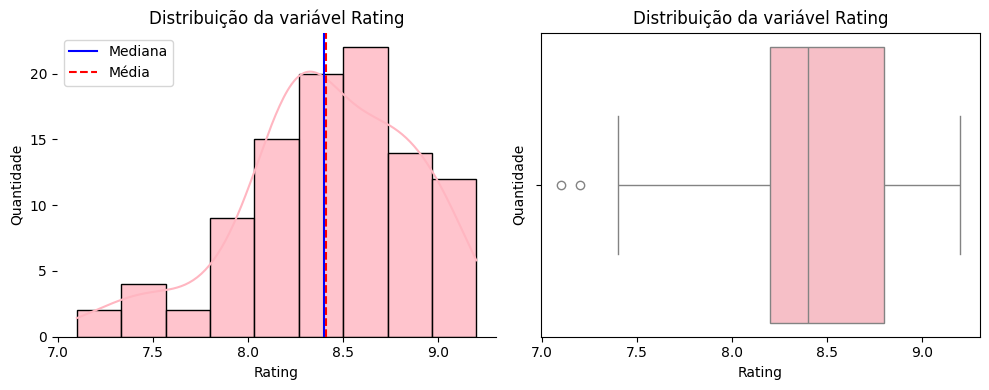

In [335]:
variavel = 'Rating'

fig, axes = plt.subplots(figsize=(10, 4), ncols=2)

ax = sns.histplot(data=drama_Rating, x=variavel, ax=axes[0], kde=True, alpha=.8, color='lightpink')
ax.axvline(drama_Rating[variavel].median(), color="blue", label="Mediana")
ax.axvline(drama_Rating[variavel].mean(), color="red", linestyle="--", label="Média")
ax.set(title=f"Distribuição da variável {variavel}", ylabel="Quantidade")
ax.legend()
ax.spines["bottom"].set_color("black")
ax.grid(False, axis="x")
for side in ["left", "top", "right"]:
    ax.spines[side].set_visible(False)
ax = sns.boxplot(data=drama_Rating, x=variavel, ax=axes[1], color='lightpink')
ax.set(title=f"Distribuição da variável {variavel}", ylabel="Quantidade")
ax.spines["bottom"].set_color("black")
ax.grid(False)


plt.tight_layout(h_pad=8, w_pad=8)
plt.tight_layout()
plt.plot()

O gráfico a seguir apresenta a distribuição das **Faixas de Rating** dos **K-Dramas** por **Ano de Lançamento**. Observa-se que a maioria das produções se concentra entre uma avaliação média de  `8.0 e 8.9`, especialmente nos anos de `2016`, `2017`, `2019` e `2020`. A partir de `2015`, há um aumento gradual na quantidade de dramas com `Rating` entre `9.0 e 10`, com destaque para os anos de `2020` a `2023`, sugerindo uma melhoria na qualidade das obras ou maior aceitação dessas produções pelo público. Por outro lado, os anos anteriores a `2015` apresentam um número reduzido de lançamentos, concentrados entre `7.0 e 8.9`, e ausência de *dramas* altamente avaliados, o que pode refletir um menor volume de produções populares ou de alta qualidade nesse período. Assim, é notável que há um crescimento na avaliação média das obras que se tornaram populares quanto mais recentes elas são.

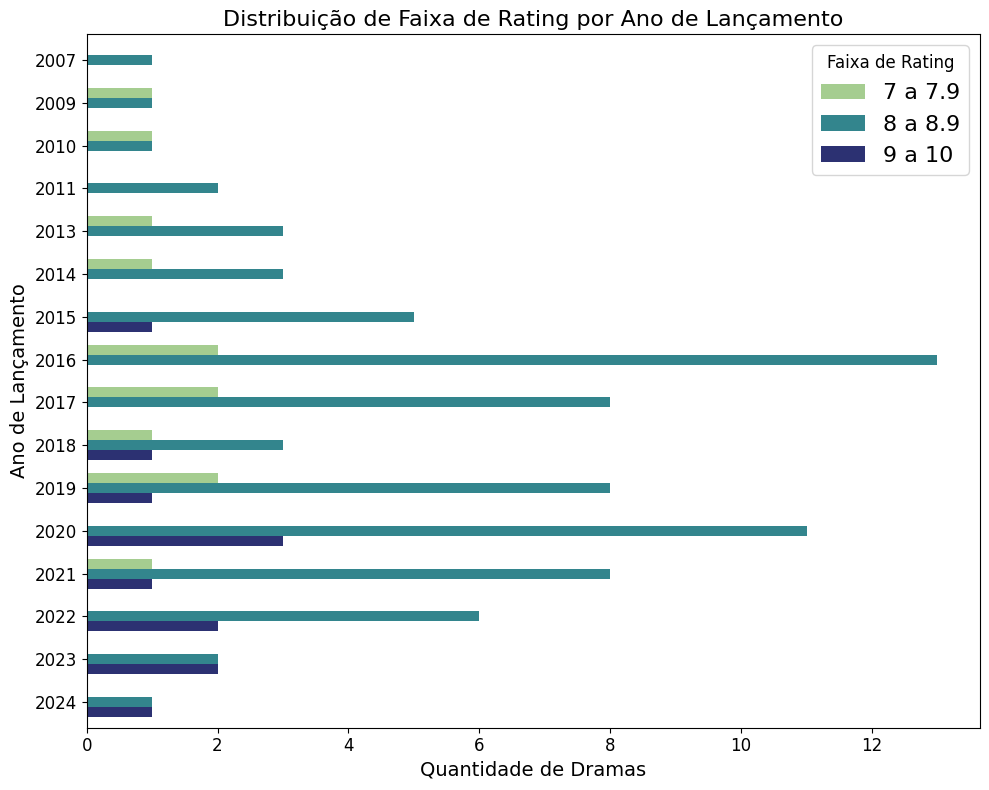

In [336]:
agrupado = pd.crosstab(drama['Year'], drama['Rating'])

fig, ax = plt.subplots(figsize=(10, 8))
agrupado.plot(kind='barh', stacked=False, colormap='crest', ax=ax, width=0.7)

ax.invert_yaxis()
ax.set_title("Distribuição de Faixa de Rating por Ano de Lançamento", fontsize=16)
ax.set_ylabel("Ano de Lançamento", fontsize=14)
ax.set_xlabel("Quantidade de Dramas", fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.legend(title="Faixa de Rating", fontsize=16, title_fontsize=12)
plt.tight_layout()
plt.show()

## **4. Teste de Hipóteses**

Utilizando o método **info**, percebemos que o *dataset* está muito extenso e inutilizável. Porém, nem todas as variáveis nele são realmente interessantes para a modelagem. Por isso, será feito um teste para descobrir aquelas que possuem uma relação mais forte com `Rating`.

In [337]:
drama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 663 entries, Name to Main Actors_Kang So Ra
dtypes: category(1), int64(661), object(1)
memory usage: 517.5+ KB


### **4.1. Verificação da associação**

É realizado uma análise de correlação entre a variável `Rating` e todas as outras colunas, exceto a coluna `Name`, que é removida inicialmente. Verifica-se a normalidade dos dados por meio do teste de **Shapiro-Wilk**. Se ambas as variáveis seguirem uma distribuição normal, aplica-se o **coeficiente de correlação de Pearson**; caso contrário, utiliza-se o **coeficiente de Spearman**. Se o p-valor for maior que 0.03, o nome da coluna é adicionado à lista `remover`, sugerindo que ela pode ser descartada da análise por não apresentar uma relação significativa com `Rating`.

In [338]:
remover = []

drama_Rating = drama_Rating.drop(columns=['Name'])

for coluna in drama_Rating:
  norm1 = stats.shapiro(drama_Rating['Rating'])[1] > 0.05
  norm2 = stats.shapiro(drama_Rating[coluna])[1] > 0.05

  if norm1 and norm2:
    corr, p = pearsonr(drama_Rating['Rating'], drama_Rating[coluna])
    metodo = 'Pearson'
  else:
    corr, p = spearmanr(drama_Rating['Rating'], drama_Rating[coluna])
    metodo = 'Spearman'

  print(f"\n\nCorrelação ({metodo}) entre {'Rating'} e {coluna}: {corr:.3f}, p-valor: {p:.4f}")

  if p < 0.03:
    print("Relação significativa entre as variáveis.")
  else:
    print("Sem evidência de relação significativa.")
    remover.append(coluna)



Correlação (Spearman) entre Rating e Year: 0.413, p-valor: 0.0000
Relação significativa entre as variáveis.


Correlação (Spearman) entre Rating e Rating: 1.000, p-valor: 0.0000
Relação significativa entre as variáveis.


Correlação (Spearman) entre Rating e Watchers: 0.202, p-valor: 0.0443
Sem evidência de relação significativa.


Correlação (Spearman) entre Rating e Episodes: -0.119, p-valor: 0.2364
Sem evidência de relação significativa.


Correlação (Spearman) entre Rating e Ep. Duration: 0.215, p-valor: 0.0316
Sem evidência de relação significativa.


Correlação (Spearman) entre Rating e Genres_Comedy: -0.243, p-valor: 0.0148
Relação significativa entre as variáveis.


Correlação (Spearman) entre Rating e Genres_Romance: -0.421, p-valor: 0.0000
Relação significativa entre as variáveis.


Correlação (Spearman) entre Rating e Genres_Fantasy: 0.096, p-valor: 0.3440
Sem evidência de relação significativa.


Correlação (Spearman) entre Rating e Genres_Melodrama: 0.045, p-valor: 0.659

### **4.2. Removendo colunas sem associação significativa**

Após a remoção das colunas, obtemos um *dataset* mais limpo, com **22 colunas**, agora ideal para seguirmos para a etapa de modelagem.

In [339]:
for coluna in remover:
    drama = drama.drop(columns=[coluna])

In [340]:
drama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Name                           100 non-null    object  
 1   Year                           100 non-null    int64   
 2   Rating                         100 non-null    category
 3   Genres_Comedy                  100 non-null    int64   
 4   Genres_Romance                 100 non-null    int64   
 5   Tags_Love Triangle             100 non-null    int64   
 6   Tags_Rich Male Lead            100 non-null    int64   
 7   Tags_Friendship                100 non-null    int64   
 8   Tags_Adapted From A Webtoon    100 non-null    int64   
 9   Tags_Male Chases Female First  100 non-null    int64   
 10  Tags_Rich Man/Poor Woman       100 non-null    int64   
 11  Tags_Comedy                    100 non-null    int64   
 12  Tags_Mean Male Lead            100 no

## **5. Partição dos dados de treinamento entre treino e validação**

Para realizar a partição dos dados, eles são então divididos em conjuntos de treino e validação, com 80% dos dados para treino e 20% para validação. Por causa do tamanho pequeno do *dataset*, foi adicionado um parâmetro que garante que a proporção das classes da variável-alvo seja mantida em ambos os conjuntos.

In [341]:
X = drama.drop('Rating', axis=1)
X = drama.drop(['Rating', 'Name'], axis=1)
y = drama['Rating']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f'Tamanho treino: {X_train.shape}')
print(f'Tamanho validação: {X_val.shape}')
print("\nDistribuição em y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição em y_val:")
print(y_val.value_counts(normalize=True))

Tamanho treino: (80, 20)
Tamanho validação: (20, 20)

Distribuição em y_train:
Rating
8 a 8.9    0.7625
9 a 10     0.1250
7 a 7.9    0.1125
Name: proportion, dtype: float64

Distribuição em y_val:
Rating
8 a 8.9    0.75
7 a 7.9    0.15
9 a 10     0.10
Name: proportion, dtype: float64


Aqui verificamos que `y_val`, que representa os valores de teste, segue uma proporção similar a `y_train`, que representa os valores de treinamento.

In [342]:
y_train.value_counts()

,count
Rating,
8 a 8.9,61
9 a 10,10
7 a 7.9,9


In [343]:
y_val.value_counts()

,count
Rating,
8 a 8.9,15
7 a 7.9,3
9 a 10,2


Como a variável `Rating` agora é categórica, foi utilizado uma encodificação para que ela possa ser corretamente associada na modelagem.

In [344]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## **6. Modelagem**

### **6.1. Modelos manualmente definidos**

In [345]:
models = []

In [346]:
X_train.columns = X_train.columns.str.replace(r"[<>\[\]\(\)]", "", regex=True)
X_val.columns = X_val.columns.str.replace(r"[<>\[\]\(\)]", "", regex=True)

modelos_manuais = {
    "Regressão Logística": LogisticRegression(max_iter=1000, random_state=42),
    "Árvore de Decisão": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, random_state=42,
                             use_label_encoder=False, eval_metric='mlogloss')
}

resultados_manuais = {}

for nome, modelo in modelos_manuais.items():
    print(f"Treinando modelo: {nome}")
    modelo.fit(X_train, y_train)
    pred_train = modelo.predict(X_train)
    pred_val = modelo.predict(X_val)

    models.append(modelo)

    resultados_manuais[nome] = {
        "Accuracy treino": accuracy_score(y_train, pred_train),
        "Accuracy validação": accuracy_score(y_val, pred_val),
        "Relatório de classificação": classification_report(y_val, pred_val, output_dict=True)
    }

df_resultados = pd.DataFrame({
    nome: {
        "Accuracy treino": valores["Accuracy treino"],
        "Accuracy validação": valores["Accuracy validação"]
    }
    for nome, valores in resultados_manuais.items()
}).T.sort_values("Accuracy validação", ascending=False)

df_resultados


Treinando modelo: Regressão Logística
Treinando modelo: Árvore de Decisão
Treinando modelo: Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c

Treinando modelo: XGBoost


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy treino,Accuracy validação
Regressão Logística,0.8375,0.85
Árvore de Decisão,0.8750,0.80
Random Forest,0.9000,0.80
XGBoost,0.8000,0.80


- A `Regressão Logística` apresentou a maior acurácia na validação `0.85`, indicando melhor capacidade de generalização entre os modelos, apesar de ter uma acurácia de treino mais baixa `0.8375`, há um menor risco de *overfitting*.

- A `Árvore de Decisão` e o `Random Forest` obtiveram alta acurácia no treino, `0.875 e 0.90`, respectivamente, mas caíram para `0.80` na validação, indicando possível *overfitting*.

- O `XGBoost` apresentou desempenho um inferior, com acurácia de `0.80` tanto no treino quanto na validação, o que pode indicar *underfitting*.

### **6.2. Modelos otimamente definidos**

In [347]:
models_optimazed = []

In [348]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

X_train.columns = X_train.columns.str.replace(r"[<>\[\]\(\)]", "", regex=True)
X_val.columns = X_val.columns.str.replace(r"[<>\[\]\(\)]", "", regex=True)

melhores_modelos = {}
resultados_otimizados = {}

param_logreg = {
    'C': uniform(0.01, 10),
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500, 1000]
}

logreg = LogisticRegression(random_state=42)
rs_logreg = RandomizedSearchCV(logreg, param_logreg, n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
rs_logreg.fit(X_train, y_train_encoded)

param_tree = {
    'max_depth': randint(2, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

tree = DecisionTreeClassifier(random_state=42)
rs_tree = RandomizedSearchCV(tree, param_tree, n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
rs_tree.fit(X_train, y_train_encoded)

param_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf = RandomForestClassifier(random_state=42)
rs_rf = RandomizedSearchCV(rf, param_rf, n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
rs_rf.fit(X_train, y_train_encoded)

param_xgb = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5)
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
rs_xgb = RandomizedSearchCV(xgb, param_xgb, n_iter=10, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
rs_xgb.fit(X_train, y_train_encoded)

for nome, busca in {
    "Regressão Logística (Ot)": rs_logreg,
    "Árvore de Decisão (Ot)": rs_tree,
    "Random Forest (Ot)": rs_rf,
    "XGBoost (Ot)": rs_xgb
}.items():
    modelo = busca.best_estimator_
    melhores_modelos[nome] = modelo

    pred_train = modelo.predict(X_train)
    pred_val = modelo.predict(X_val)

    models_optimazed.append(modelo)

    resultados_otimizados[nome] = {
        "Accuracy treino": accuracy_score(y_train_encoded, pred_train),
        "Accuracy validação": accuracy_score(y_val_encoded, pred_val),
        "Relatório de classificação": classification_report(y_val_encoded, pred_val, output_dict=True, zero_division=0)
    }

df_otimizados = pd.DataFrame({
    nome: {
        "Accuracy treino": valores["Accuracy treino"],
        "Accuracy validação": valores["Accuracy validação"]
    }
    for nome, valores in resultados_otimizados.items()
}).T.sort_values("Accuracy validação", ascending=False)

df_otimizados


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:07:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Accuracy treino,Accuracy validação
Regressão Logística (Ot),0.8250,0.85
Árvore de Decisão (Ot),0.8500,0.80
XGBoost (Ot),0.8375,0.80
Random Forest (Ot),0.7625,0.75


- A `Regressão Logística` manteve a acurácia de validação em `0.85`, sendo novamente o modelo de melhor generalização, e com leve redução na acurácia de treino `0.8250`, o que sugere, mais uma vez, menor risco de *overfitting*.

- A `Árvore de Decisão` apresentou desempenho semelhante ao anterior, com `0.85` no treino e `0.80` na validação — resultado estável, mas com indícios de ajuste próximo ao limite da generalização.

- O `XGBoost` também manteve boa performance com `0.8375` no treino e `0.80` na validação, se mostrando um modelo consistente e equilibrado após a otimização.

- A `Random Forest` teve queda considerável na acurácia de treino, `0.7625` e na validação `0.75`, indicando que a busca aleatória pode não ter encontrado hiperparâmetros ideais.

### **6.3. Medidas de desempenho**

In [349]:
print("\nModelos manualmente definidos:")
for model in models:
  print(f"\n-> Avaliação {model.__class__.__name__}:")
  print("\nAccuracy treino:", accuracy_score(y_train, model.predict(X_train)))
  print("Accuracy validação:", accuracy_score(y_val, model.predict(X_val)))
  print("\nRelatório completo:\n", classification_report(y_val, model.predict(X_val)))

print("\nModelos otimizados:")
for model in models_optimazed:
  print(f"\n-> Avaliação {model.__class__.__name__}:")
  print("\nAccuracy treino:", accuracy_score(y_train_encoded, model.predict(X_train)))
  print("Accuracy validação:", accuracy_score(y_val_encoded, model.predict(X_val)))
  print("\nRelatório completo:\n", classification_report(y_val_encoded, model.predict(X_val)))



Modelos manualmente definidos:

-> Avaliação LogisticRegression:

Accuracy treino: 0.8375
Accuracy validação: 0.85

Relatório completo:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.83      1.00      0.91        15
           2       1.00      0.50      0.67         2

    accuracy                           0.85        20
   macro avg       0.94      0.61      0.69        20
weighted avg       0.88      0.85      0.82        20


-> Avaliação DecisionTreeClassifier:

Accuracy treino: 0.875
Accuracy validação: 0.8

Relatório completo:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.87      0.87      0.87        15
           2       0.50      0.50      0.50         2

    accuracy                           0.80        20
   macro avg       0.68      0.68      0.68        20
weighted avg       0.80      0.80      0.80    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

- A `Regressão Logística` teve o melhor desempenho geral, tanto antes quanto após a otimização, com acurácia de `0.85`, e ainda prevê todas as classes.

- A `Árvore de Decisão` é estável e razoável, mas sofre em classe 0, de `7 a 7.9` após otimização. Isso pode ocorrer devido a essa avaliação aparecer poucas vezes no *dataset*.

- O `XGBoost` é competitivo, mas inconsistente nas classes minoritárias.

- A `Random Forest` piorou após otimização, indicando possível subajuste.

## **7. Conclusão**

Com base nas etapas desenvolvidas neste trabalho, foi possível treinar e avaliar diferentes modelos de classificação para prever a avaliação média de `K-Dramas` a partir de suas características. No entanto, é perceptível que existe um desequilíbrio no *dataset* em relação a quantidade de *dramas* em casa faixa de `Rating`, isso afetou bastante o desempenho dos modelos e suas avaliações. Ainda assim, o modelo de `Regressão Logística` e o de `XGBoost` apresentaram bom desempenho geral, especialmente npara `8.1 a 9`, onde há a maior concentração dos dados. Os resultados obtidos destacam a importância de uma análise cuidadosa das distribuições das classes e sugerem que futuras melhorias podem vir da ampliação da base de dados, pois, infelizmente, a quantidade pequena de dados se mostrou um grande limitador nesse projeto.